In [1]:
!mkdir -p data
!wget https://lnctard.bio-database.com/downloadfile/lnctard2.0.zip -qO- | zcat > data/lnctard2.0.txt

In [2]:
!pip install git+https://github.com/pykeen/pykeen.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/pykeen/pykeen.git to /tmp/pip-req-build-9cfn135b
  Running command git clone --filter=blob:none --quiet https://github.com/pykeen/pykeen.git /tmp/pip-req-build-9cfn135b
  Resolved https://github.com/pykeen/pykeen.git to commit cb226fc1ff946f0bc6c1296ea5d3ee87a4ef773b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 7.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 4.8 MB/s eta 0:00:00
     ━━━

In [3]:
import os

import numpy as np
import pandas as pd
import pykeen
from pykeen.pipeline import pipeline
from pykeen.triples.leakage import Sealant
from pykeen.triples import TriplesFactory

from matplotlib import pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

INFO:pykeen.utils:Using opt_einsum


In [4]:
pykeen.env()

Key,Value
OS,posix
Platform,Linux
Release,5.15.107+
Time,Sat Jun 17 20:39:11 2023
Python,3.10.12
PyKEEN,1.10.2-dev
PyKEEN Hash,UNHASHED
PyKEEN Branch,
PyTorch,2.0.1+cu118
CUDA Available?,false


In [5]:
!wget https://raw.githubusercontent.com/pykeen/pykeen/master/notebooks/learn_from_bel/ras_machine_triples.tsv -O ./data/ras_machine_triples.tsv

--2023-06-17 20:39:12--  https://raw.githubusercontent.com/pykeen/pykeen/master/notebooks/learn_from_bel/ras_machine_triples.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 566628 (553K) [text/plain]
Saving to: ‘./data/ras_machine_triples.tsv’

./data/ras_machine_ 100%[===================>] 553.35K  --.-KB/s    in 0.05s   

2023-06-17 20:39:12 (10.8 MB/s) - ‘./data/ras_machine_triples.tsv’ saved [566628/566628]



In [8]:
df = pd.read_csv("data/lnctard2.0.txt", sep="\t", encoding="latin-1", dtype="string")
df = df[["Regulator", "SearchregulatoryMechanism", "Target"]].drop_duplicates().reset_index(drop=True).to_numpy()
print(df)

[['LINC00313' 'ceRNA or sponge' 'miR-4429']
 ['FAM83H-AS1' 'epigenetic regulation' 'CDKN1A']
 ['NEAT1' 'ceRNA or sponge' 'TGFB1']
 ...
 ['IQANK1' 'ceRNA or sponge' 'MEF2D']
 ['HCG22' 'ceRNA or sponge' 'miR-650']
 ['PVT1' 'expression association' 'FOXM1']]


In [9]:
tf = TriplesFactory.from_labeled_triples(df)

In [10]:
training, valid, testing = tf.split([0.8, 0.1, 0.1], random_state=1234)

INFO:pykeen.triples.splitting:done splitting triples to groups of sizes [2822, 744, 744]


In [16]:
transe = pipeline(
    training=training,
    validation=valid,
    testing=testing,
    model="TransE",
    # model_kwargs=dict(embedding_dim=512),
    training_kwargs=dict(use_tqdm_batch=False, num_epochs=50),
    evaluation_kwargs=dict(use_tqdm=False),
    random_seed=1,
    device="cuda",
)

INFO:pykeen.pipeline.api:Using device: cuda


Training epochs on cpu:   0%|          | 0/50 [00:00<?, ?epoch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.
INFO:pykeen.evaluation.evaluator:Evaluation took 4.54s seconds


<Axes: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>

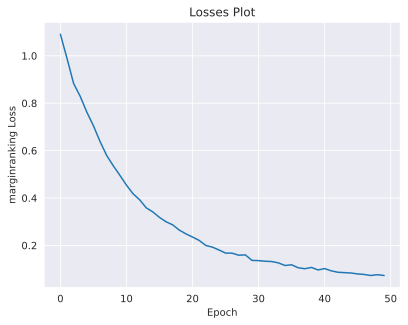

In [17]:
transe.plot_losses()

In [18]:
transe.metric_results.to_df()

,Side,Type,Metric,Value
0,head,optimistic,geometric_mean_rank,303.776894
1,tail,optimistic,geometric_mean_rank,469.189126
2,both,optimistic,geometric_mean_rank,377.529887
3,head,realistic,geometric_mean_rank,303.777130
4,tail,realistic,geometric_mean_rank,469.189240
...,...,...,...,...
220,tail,realistic,adjusted_hits_at_k,0.033801
221,both,realistic,adjusted_hits_at_k,0.036501
222,head,pessimistic,adjusted_hits_at_k,0.039201
223,tail,pessimistic,adjusted_hits_at_k,0.033801


In [15]:
transe.save_to_directory("results/transe")

INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=3908, num_relations=7, create_inverse_triples=False, num_triples=5950) to file:///content/results/transe/training_triples
INFO:pykeen.pipeline.api:Saved to directory: /content/results/transe


In [19]:
rotate = pipeline(
    training=training,
    validation=valid,
    testing=testing,
    model="RotatE",
    # model_kwargs=dict(embedding_dim=512),
    training_kwargs=dict(use_tqdm_batch=False, num_epochs=50),
    evaluation_kwargs=dict(use_tqdm=False),
    random_seed=1,
    device="cuda",
)

INFO:pykeen.pipeline.api:Using device: cuda


Training epochs on cpu:   0%|          | 0/50 [00:00<?, ?epoch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.
INFO:pykeen.evaluation.evaluator:Evaluation took 42.60s seconds


<Axes: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>

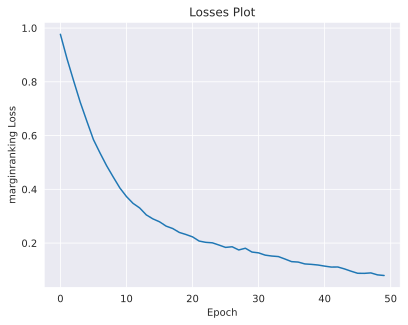

In [20]:
rotate.plot_losses()

In [21]:
rotate.metric_results.to_df()

,Side,Type,Metric,Value
0,head,optimistic,geometric_mean_rank,145.052918
1,tail,optimistic,geometric_mean_rank,117.400634
2,both,optimistic,geometric_mean_rank,130.496378
3,head,realistic,geometric_mean_rank,145.052887
4,tail,realistic,geometric_mean_rank,117.400612
...,...,...,...,...
220,tail,realistic,adjusted_hits_at_k,0.144301
221,both,realistic,adjusted_hits_at_k,0.095120
222,head,pessimistic,adjusted_hits_at_k,0.045939
223,tail,pessimistic,adjusted_hits_at_k,0.144301


In [22]:
rotate.save_to_directory("results/rotate")

INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=3908, num_relations=7, create_inverse_triples=False, num_triples=5950) to file:///content/results/rotate/training_triples
INFO:pykeen.pipeline.api:Saved to directory: /content/results/rotate
